In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=15.5s


In [4]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load gene annotation

In [5]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

In [6]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


### Load comparison gene sets

In [7]:
dic_geneset = {}

# Load KEGG ALZ geneset
fname = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'\
        'msigdb_v7.1_files_to_download_locally/msigdb_v7.1_GMTs/c2.cp.kegg.v7.1.symbols.gmt'
with open(fname, 'r') as f:
    for i_line,line in enumerate(f):
        if 'ALZH' in line: break
dic_geneset['kegg_alz'] = [dic_mapping[x.strip()] for x in line.split('\t')[2:] 
                           if x.strip() in dic_mapping.keys()]

# Load Forgetta et al. genes 
temp_path='/n/home12/khou/scTRS/gene_sets/out/processed/silver_omim' 
for fname in os.listdir(temp_path):
    trait = fname.replace('.csv', '')
    dic_geneset['silver_%s_omim'%trait] = [dic_mapping[x] for x in pd.read_csv(temp_path+'/'+fname, sep=',')['GENE']
                                           if x in dic_mapping.keys()]

temp_path='/n/home12/khou/scTRS/gene_sets/out/processed/silver_drug' 
for fname in os.listdir(temp_path):
    trait = fname.replace('.csv', '')
    dic_geneset['silver_%s_drug'%trait] = [dic_mapping[x] for x in pd.read_csv(temp_path+'/'+fname, sep=',')['GENE']
                                           if x in dic_mapping.keys()]
    
# Print all genesets 
geneset_list = list(dic_geneset.keys())
geneset_list.sort()
for gs in geneset_list:
    print('# %-30s n_gene=%d'%(gs, len(dic_geneset[gs])))

# kegg_alz                       n_gene=137
# silver_calcium_drug            n_gene=6
# silver_calcium_omim            n_gene=4
# silver_dbilirubin_omim         n_gene=1
# silver_dbp_drug                n_gene=13
# silver_dbp_omim                n_gene=13
# silver_ebmd_drug               n_gene=8
# silver_ebmd_omim               n_gene=53
# silver_glucose_drug            n_gene=15
# silver_glucose_omim            n_gene=58
# silver_height_drug             n_gene=2
# silver_height_omim             n_gene=60
# silver_ldl_drug                n_gene=5
# silver_ldl_omim                n_gene=17
# silver_lowtsh_drug             n_gene=4
# silver_lowtsh_omim             n_gene=7
# silver_rbc_drug                n_gene=6
# silver_rbc_omim                n_gene=58
# silver_sbp_drug                n_gene=13
# silver_sbp_omim                n_gene=13
# silver_t2d_drug                n_gene=7
# silver_t2d_omim                n_gene=45
# silver_tg_drug                 n_gene=6
# silver_tg_omim     

In [65]:
dic_gs_map = {'kegg_alz': 'PASS_Alzheimers_Jansen2019',
                'silver_calcium_drug': 'UKB_460K.biochemistry_Calcium',
                'silver_calcium_omim': 'UKB_460K.biochemistry_Calcium',
                'silver_dbilirubin_omim': 'UKB_460K.biochemistry_DirectBilirubin',
                'silver_dbp_drug': 'UKB_460K.bp_DIASTOLICadjMEDz',
                'silver_dbp_omim': 'UKB_460K.bp_DIASTOLICadjMEDz',
                'silver_glucose_drug':'UKB_460K.biochemistry_Glucose',
                'silver_glucose_omim':'UKB_460K.biochemistry_Glucose',
                'silver_height_drug': 'UKB_460K.body_HEIGHTz',
                'silver_height_omim': 'UKB_460K.body_HEIGHTz',
                'silver_ldl_drug': 'UKB_460K.biochemistry_LDLdirect;PASS_LDL',
                'silver_ldl_omim': 'UKB_460K.biochemistry_LDLdirect;PASS_LDL',
                'silver_lowtsh_drug':'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
                'silver_lowtsh_omim':'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
                'silver_rbc_drug': 'UKB_460K.blood_RED_COUNT', 
                'silver_rbc_omim': 'UKB_460K.blood_RED_COUNT', 
                'silver_t2d_drug': 'UKB_460K.disease_T2D', 
                'silver_t2d_omim': 'UKB_460K.disease_T2D', 
                'silver_tg_drug': 'UKB_460K.biochemistry_Triglycerides',
                'silver_tg_omim': 'UKB_460K.biochemistry_Triglycerides'}

dic_gs_map = {'kegg_alz': 'PASS_Alzheimers_Jansen2019',
              'silver_ldl_omim': 'PASS_LDL'}

### Trait association

In [9]:
# Precompute mean and var 
md.compute_stats(data_facs_ct)

In [10]:
# Trait list
trait_list = []
for gs in dic_gs_map.keys():
    trait_list += dic_gs_map[gs].split(';')
trait_list = list(set(trait_list))
trait_list.sort()

# Tissue and tc list
tissue_list = list(set(data_facs_ct.obs['tissue']))
tissue_list.sort()
tc_list = list(set(data_facs_ct.obs['tissue_celltype']))
tc_list.sort()

print('# facs data: n_tissue=%d n_tissue_celltype=%d'%(len(tissue_list), len(tc_list)))

dic_trs_geneset = {}
for trait in trait_list:
    # Find FDR<0.01 genes 
    temp_df = df_geneannot[[trait]].copy()
    temp_df.columns = ['z_score']
    temp_df['p_val'] = 1 - sp.stats.norm.cdf(temp_df['z_score'].values)
    temp_df['fdr'] = multipletests(temp_df['p_val'].values, method='fdr_bh')[1]
    dic_trs_geneset[trait] = temp_df.copy()
    print('# %-40s n_gene=%d'%(trait, (temp_df['fdr'].values<0.1).sum()))

# facs data: n_tissue=23 n_tissue_celltype=207
# PASS_Alzheimers_Jansen2019               n_gene=298
# PASS_LDL                                 n_gene=460


In [11]:
# Obtain TRS
dic_trs = {}
start_time = time.time()
for trait in trait_list:
    
#     # Top 500 genes
#     gene_list = list(dic_trs_geneset[trait].sort_values(by='fdr').index[0:500])
    
    ind_select = (dic_trs_geneset[trait]['fdr'].values<0.1)
    gene_list = dic_trs_geneset[trait].index[ind_select]
    
    # mean, n_genes
    md.score_cell(data_facs_ct, gene_list, suffix='',
                  ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                  n_ctrl=10, n_genebin=200, cov_list=['mean', 'n_genes'],
                  return_list=['trs', 'trs_z', 'trs_ep', 'trs_ez'], verbose=False)
    
    dic_trs['%s;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
    dic_trs['%s;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
    dic_trs['%s;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
    dic_trs['%s;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()
    
    print('# %-40s time=%0.1fs'%(trait,time.time()-start_time))

# PASS_Alzheimers_Jansen2019               time=11.5s
# PASS_LDL                                 time=23.4s


In [12]:
# Find number of associated cells for each tissue/tissue_celltype

dic_assoc = {'tissue': pd.DataFrame(index=tissue_list, columns=trait_list, data=0),
             'tissue-celltype': pd.DataFrame(index=tc_list, columns=trait_list, data=0)}

df_obs = data_facs_ct.obs.copy()

for trait in trait_list:
    
    v_p = dic_trs['%s;trs_ep'%trait]
    v_fdr = multipletests(v_p, method='fdr_bh')[1]
    
    # tissue
    temp_df = df_obs.loc[v_fdr<0.4].copy()
    temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue'].loc[temp_df.index, trait] = temp_df['cell'].values
    
    # tissue-cell
    temp_df = df_obs.loc[v_fdr<0.4].copy().copy()
    temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue-celltype'].loc[temp_df.index, trait] = temp_df['cell'].values

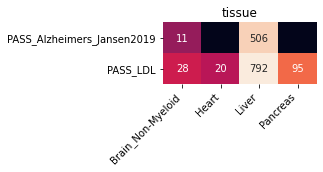

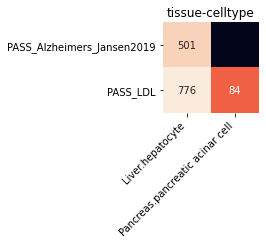

In [13]:
def num2str(x):
    if x>1000:
        return '%0.1fk'%(x/1000)
    elif x>0:
        return '%d'%x
    else:
        return ''
    
for term in dic_assoc.keys():

    df_plot = dic_assoc[term].copy()
    df_plot = df_plot.loc[df_plot.max(axis=1)>10]
    df_plot = df_plot.T
    df_plot[df_plot<10] = 0
    
    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    
    plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1*('tissue-celltype' in term)])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.title(term)
    plt.tight_layout()
    plt.show()

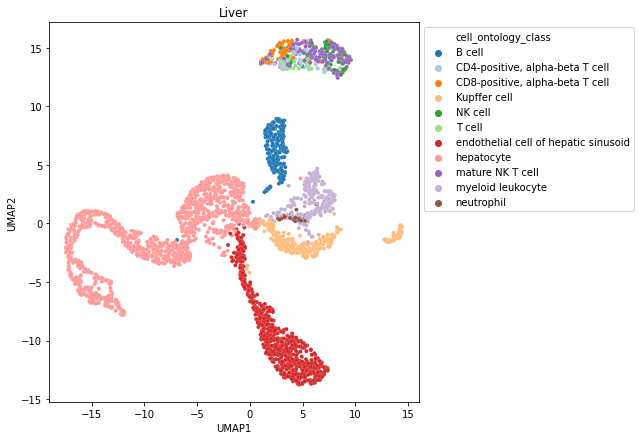

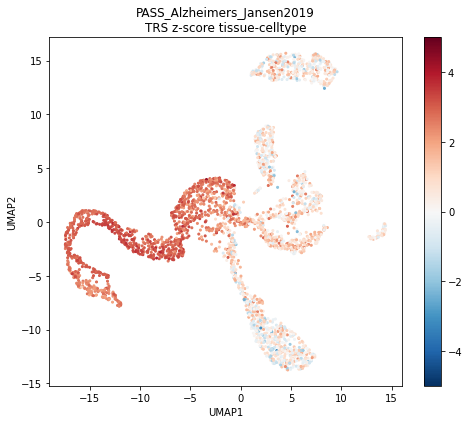

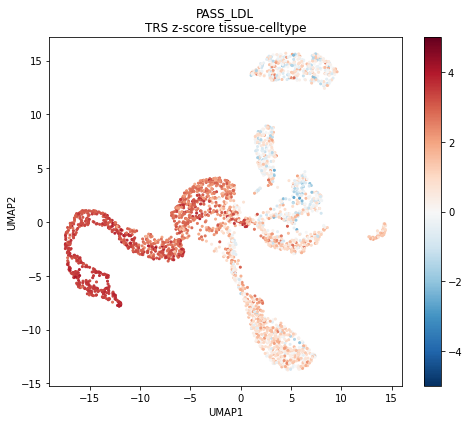

In [14]:
plot_list = [['Liver', 'PASS_Alzheimers_Jansen2019'],
             ['Liver', 'PASS_LDL']]

tissue_plot = []
for tissue,trait in plot_list:
    
    temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
    temp_df['trs_ez'] = dic_trs['%s;trs_ez'%(trait)]
    
    df_plot = pd.DataFrame(index=dic_data_facs[tissue].obs.index)
    df_plot['UMAP1'] = dic_data_facs[tissue].obsm['X_umap'][:,0]
    df_plot['UMAP2'] = dic_data_facs[tissue].obsm['X_umap'][:,1]
    df_plot['cell_ontology_class'] = dic_data_facs[tissue].obs['cell_ontology_class']
    
    df_plot['trs_ez'] = temp_df.loc[df_plot.index, 'trs_ez']
    
    temp_df = df_plot.groupby('cell_ontology_class').agg({'trs_ez':len})
    celltype_list = list(temp_df.index[temp_df['trs_ez']>25])
    celltype_list.sort()
    celltype_set = set(celltype_list)
    df_plot = df_plot.loc[[x in celltype_set for x in df_plot['cell_ontology_class']]]
    
    if len(celltype_list)<=10:
        palette='tab10'
    else:
        palette='tab20'
    
    if tissue not in tissue_plot:
        tissue_plot.append(tissue)
        plt.figure(figsize=[9,6])
        sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', 
                        hue='cell_ontology_class', hue_order=celltype_list, palette=palette,
                        s=16, linewidth=0.1)
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))
        plt.tight_layout()
        plt.title(tissue)
        plt.show()
    
    plt.figure(figsize=[7,6])
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['trs_ez'],
                cmap='RdBu_r', vmin=-5, vmax=5, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s\nTRS z-score %s'%(trait, term.replace('trs_ez','').replace(';','')))
    plt.tight_layout()
    plt.show()
#     break

### Would cell-cycle explain the heterogeneity?
Score cell method from https://github.com/theislab/single-cell-tutorial/blob/master/latest_notebook/Case-study_Mouse-intestinal-epithelium_1906.ipynb

In [15]:
# Score cell cycle and visualize the effect 
cc_genes_file='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/Macosko_cell_cycle_genes.txt'
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_mm_ens = data_facs_ct.var_names[np.in1d(data_facs_ct.var_names, s_genes_mm)]
g2m_genes_mm_ens = data_facs_ct.var_names[np.in1d(data_facs_ct.var_names, g2m_genes_mm)]

sc.tl.score_genes_cell_cycle(data_facs_ct, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens)

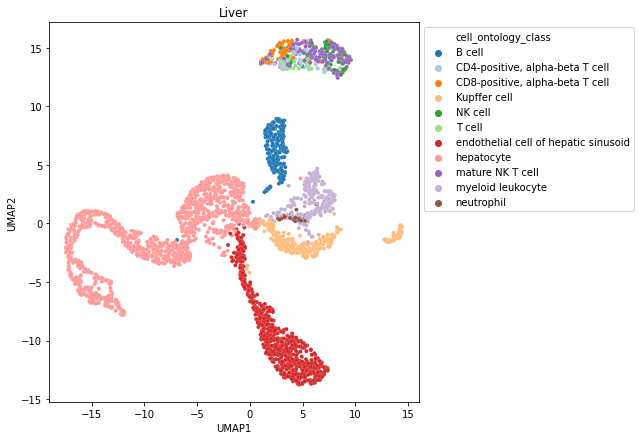

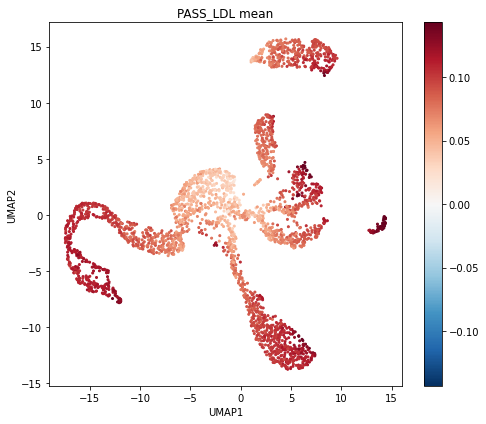

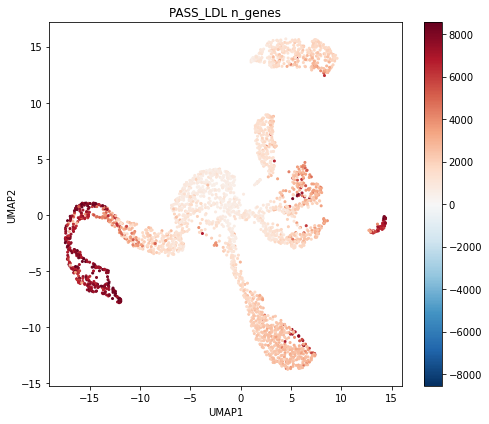

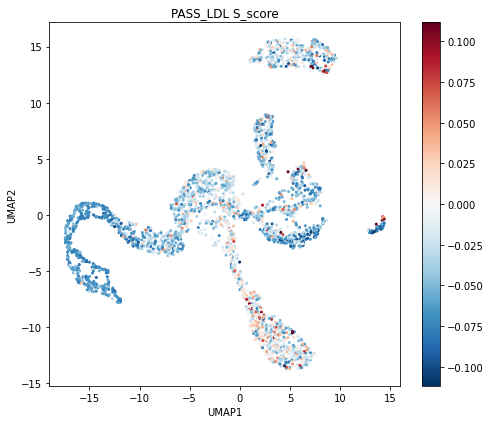

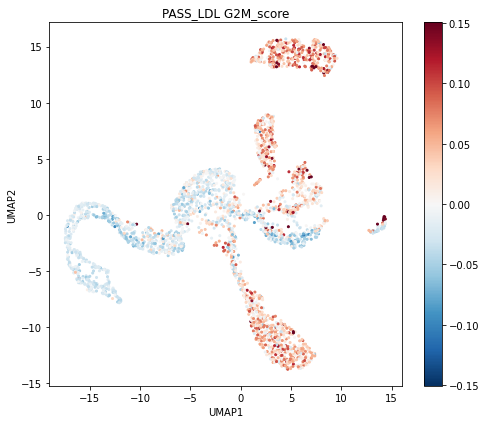

In [16]:
cov_list = ['mean', 'n_genes', 'S_score', 'G2M_score']
tissue = 'Liver'

df_plot = pd.DataFrame(index=dic_data_facs[tissue].obs.index)
df_plot['UMAP1'] = dic_data_facs[tissue].obsm['X_umap'][:,0]
df_plot['UMAP2'] = dic_data_facs[tissue].obsm['X_umap'][:,1]
df_plot['cell_ontology_class'] = dic_data_facs[tissue].obs['cell_ontology_class']
df_plot = df_plot.join(data_facs_ct.obs[cov_list])

temp_df = df_plot.groupby('cell_ontology_class').agg({'UMAP1':len})
celltype_list = list(temp_df.index[temp_df['UMAP1']>25])
celltype_list.sort()
celltype_set = set(celltype_list)
df_plot = df_plot.loc[[x in celltype_set for x in df_plot['cell_ontology_class']]]

# Tissue plot
plt.figure(figsize=[9,6])
sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', 
                hue='cell_ontology_class', hue_order=celltype_list, palette='tab20',
                s=16, linewidth=0.1)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.title(tissue)
plt.show()

# Covariate plot
for cov in cov_list:
    plt.figure(figsize=[7,6])

    max_ = np.quantile(np.absolute(df_plot[cov].values), 0.99)
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[cov],
                cmap='RdBu_r', vmax=max_, vmin=-max_, s=4)
    plt.colorbar()
    
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s %s'%(trait, cov))
    plt.tight_layout()
    plt.show()

### TRS-correlated genes

In [57]:
df_gene_corr = pd.DataFrame(index=data_facs_ct.var_names)
trs_name = 'trs_ez'

for trait in trait_list:  
    
    print(trait)
    
    # Liver
    ind_select = (data_facs_ct.obs['tissue']=='Liver')
    temp_adata = data_facs_ct[ind_select,:].copy()
    temp_adata.obs['trs_ez'] = dic_trs['%s;trs_ez'%trait][ind_select]
    
    md.correlate_gene(temp_adata, trs_name=trs_name, corr_opt='pearson', cov_list=None)
    df_gene_corr['%s;liver;cov_none'%(trait)] = temp_adata.var[['trs_corr']].copy()
    
    md.correlate_gene(temp_adata, trs_name=trs_name, corr_opt='pearson', cov_list=['mean','n_genes'])
    df_gene_corr['%s;liver;cov_mean_ngene'%(trait)] = temp_adata.var[['trs_corr']].copy()
        
    # Liver hepatocyte
    ind_select = (data_facs_ct.obs['tissue']=='Liver')&(data_facs_ct.obs['cell_ontology_class']=='hepatocyte')
    temp_adata = data_facs_ct[ind_select,:].copy()
    temp_adata.obs['trs_ez'] = dic_trs['%s;trs_ez'%trait][ind_select]
    
    md.correlate_gene(temp_adata, trs_name=trs_name, corr_opt='pearson', cov_list=None)
    df_gene_corr['%s;hep;cov_none'%(trait)] = temp_adata.var[['trs_corr']].copy()
    
    md.correlate_gene(temp_adata, trs_name=trs_name, corr_opt='pearson', cov_list=['mean','n_genes'])
    df_gene_corr['%s;hep;cov_mean_ngene'%(trait)] = temp_adata.var[['trs_corr']].copy()

PASS_Alzheimers_Jansen2019
PASS_LDL


In [58]:
# Baseline1: correlation with n_genes 
ind_select = (data_facs_ct.obs['tissue']=='Liver')&(data_facs_ct.obs['cell_ontology_class']=='hepatocyte')
temp_adata = data_facs_ct[ind_select,:].copy()
temp_adata.obs['trs_ez'] = dic_trs['%s;trs_ez'%trait][ind_select]
    
md.correlate_gene(temp_adata, trs_name='n_genes', corr_opt='pearson', cov_list=None)
df_gene_corr['bl_ngene'] = temp_adata.var[['trs_corr']].copy()


# Baseline2: hepatpcyte-specific genes
ind_select = (data_facs_ct.obs['tissue']=='Liver')
temp_adata = data_facs_ct[ind_select,:].copy()
sc.tl.rank_genes_groups(temp_adata, groupby='cell_ontology_class', groups=['hepatocyte'], 
                        n_genes=temp_adata.shape[1])

temp_df = pd.DataFrame(index = [x[0] for x in temp_adata.uns['rank_genes_groups']['names']])
temp_df['bl_hep_spec'] = [x[0] for x in temp_adata.uns['rank_genes_groups']['scores']]
df_gene_corr = df_gene_corr.join(temp_df)

... storing 'tissue_celltype' as categorical
... storing 'phase' as categorical


# kegg_alz                       n_gene=133/137


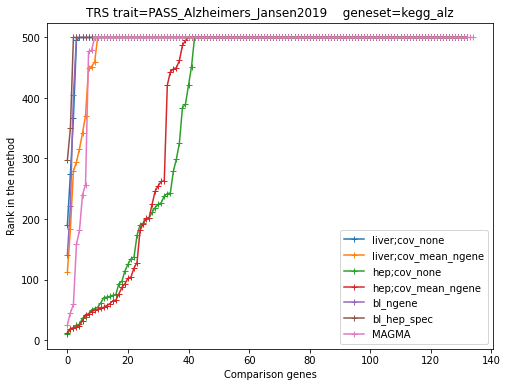

# silver_ldl_omim                n_gene=17/17


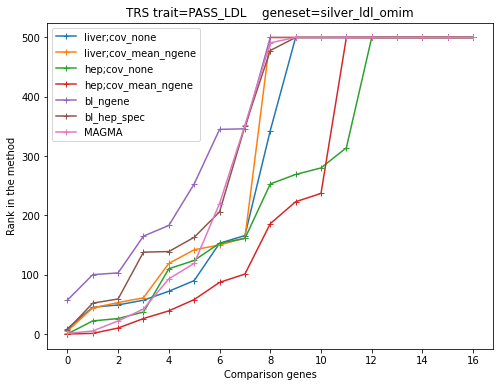

In [68]:
gs_common = set(df_geneannot.index) & set(df_gene_corr.index)

for gs in dic_gs_map.keys():
    
    gs_list = dic_geneset[gs].copy()
    gs_list = list(set(gs_list) & gs_common)
    print('# %-30s n_gene=%d/%d'%(gs, len(gs_list), len(dic_geneset[gs])))
    tar_trait = dic_gs_map[gs].split(';')[0]
    
    # Rank based on TRS-correlation
    dic_trs_rank = {}
    for col in df_gene_corr.columns:
        if (tar_trait in col) | ('bl_' in col):
            temp_df = df_gene_corr[[col]].copy()
            temp_df.sort_values(by=col, inplace=True, ascending=False)
            temp_df['rank'] = np.arange(temp_df.shape[0])
    
            rank_trs = list(temp_df.loc[gs_list, 'rank'].values)
            rank_trs.sort()
            v_rank_trs = np.array(rank_trs).clip(max=500)
            dic_trs_rank[col.replace(tar_trait+';','')] = v_rank_trs
    
    # Rank based on MAGMA z-score
    temp_df = dic_trs_geneset[tar_trait].copy()
    temp_df.sort_values(by='z_score', inplace=True, ascending=False)
    temp_df['rank'] = np.arange(temp_df.shape[0])
    
    rank_magma = list(temp_df.loc[gs_list, 'rank'].values)
    rank_magma.sort()
    v_rank_magma = np.array(rank_magma).clip(max=500)    
    
    plt.figure(figsize=[8,6])
    for term in dic_trs_rank.keys():
        v_rank_trs = dic_trs_rank[term]
        plt.plot(np.arange(v_rank_trs.shape[0]), v_rank_trs, '+-', label=term)
    plt.plot(np.arange(v_rank_magma.shape[0]), v_rank_magma, '+-', label='MAGMA')
    plt.legend()
    plt.ylabel('Rank in the method')
    plt.xlabel('Comparison genes')
    plt.title('TRS trait=%s    geneset=%s'%(tar_trait, gs))
    plt.show()

### Old code 

### Compare MAGMA genes and TRS-corr genes on a reference GWAS data

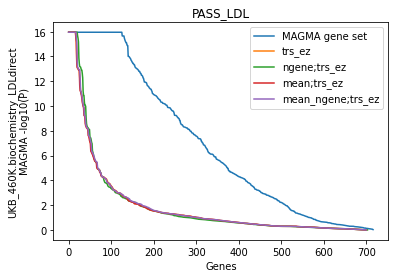

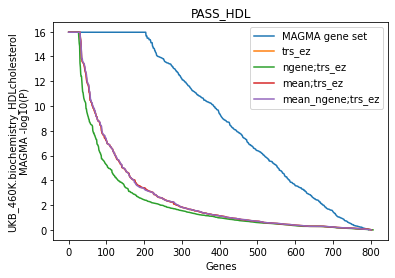

In [69]:
plot_list = [['PASS_LDL', 'UKB_460K.biochemistry_LDLdirect'],
             ['PASS_HDL', 'UKB_460K.biochemistry_HDLcholesterol']]

for tar_trait,ref_trait in plot_list:
    
    df_ref_trait = dic_geneset[ref_trait].copy()
    df_ref_trait.loc[df_ref_trait['p_val']==0,'p_val'] = \
        df_ref_trait.loc[df_ref_trait['p_val']>0,'p_val'].min()
    df_ref_trait['nlog10p'] = -np.log10(df_ref_trait['p_val'].values)
    
    # MAGMA geneset 
    ind_select = (dic_geneset[tar_trait]['fdr'].values<0.2)
    magma_gene_list = list(set(dic_geneset[tar_trait].index[ind_select]))
    
    plt.figure()
    v_nlogp = df_ref_trait.loc[magma_gene_list,'nlog10p'].values
    v_nlogp = np.sort(v_nlogp)[::-1]
    plt.plot(np.arange(v_nlogp.shape[0]), v_nlogp, c='C0', label='MAGMA gene set')

    
    for iterm,term in enumerate(['trs_ez', 'ngene;trs_ez', 'mean;trs_ez', 'mean_ngene;trs_ez']):
        
        # TRS-correlated geneset
        overlap_gene_list = list(set(df_gene_corr.index)&set(dic_geneset[tar_trait].index))
        temp_df = df_gene_corr.loc[overlap_gene_list, ['%s;%s'%(tar_trait,term)]].copy()
        temp_df.sort_values(by='%s;%s'%(tar_trait,term), inplace=True)
        trscorr_gene_list =  list(temp_df.index[-len(magma_gene_list):])
        
        v_nlogp = df_ref_trait.loc[trscorr_gene_list,'nlog10p'].values
        v_nlogp = np.sort(v_nlogp)[::-1]
        plt.plot(np.arange(v_nlogp.shape[0]), v_nlogp, c='C%d'%(iterm+1), label=term)

    plt.ylabel('%s\nMAGMA -log10(P)'%ref_trait)
    plt.xlabel('Genes')
    plt.legend()
    plt.title(tar_trait)
    plt.show()

### Pathway analysis

In [71]:
from gprofiler import GProfiler
dic_pathway = {}
for trait in trait_list:
    for iterm,term in enumerate(['trs_ez', 'ngene;trs_ez']):

        temp_df = df_gene_corr[['%s;%s'%(trait,term)]].copy()
        temp_df.sort_values(by='%s;%s'%(trait,term), inplace=True)
        gene_list = list(temp_df.index[-100:])

        gp = GProfiler(return_dataframe=True)
        df_pathway = gp.profile(organism='mmusculus', query=gene_list,
                                sources=['GO:BP', 'KEGG'], significance_threshold_method='fdr', 
                                user_threshold=0.01, background=list(data_facs_ct.var_names))
        dic_pathway['%s;%s'%(trait,term)] = df_pathway.copy()
        print(trait, term)

PASS_Alzheimers_Jansen2019 trs_ez
PASS_Alzheimers_Jansen2019 ngene;trs_ez
PASS_HDL trs_ez
PASS_HDL ngene;trs_ez
PASS_LDL trs_ez
PASS_LDL ngene;trs_ez
UKB_460K.biochemistry_HDLcholesterol trs_ez
UKB_460K.biochemistry_HDLcholesterol ngene;trs_ez
UKB_460K.biochemistry_LDLdirect trs_ez
UKB_460K.biochemistry_LDLdirect ngene;trs_ez
PASS_BipolarDisorder_Ruderfer2018 trs_ez
PASS_BipolarDisorder_Ruderfer2018 ngene;trs_ez
PASS_Schizophrenia_Pardinas2018 trs_ez
PASS_Schizophrenia_Pardinas2018 ngene;trs_ez
PASS_Rheumatoid_Arthritis trs_ez
PASS_Rheumatoid_Arthritis ngene;trs_ez
UKB_460K.body_HEIGHTz trs_ez
UKB_460K.body_HEIGHTz ngene;trs_ez


In [74]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('./pathway_top100.101320.xlsx', engine='xlsxwriter')
for term in dic_pathway.keys():
    temp_df = dic_pathway[term].copy()
    ind_select = (temp_df['term_size']<1000)&(temp_df['precision']>0.2)
    temp_df.loc[ind_select].to_excel(writer, sheet_name=term.split(';')[0][0:15]+';'+term.split(';')[1])
writer.save()

### Liver hepatocyte marker genes 

In [79]:
# Liver hepatocyte markers 

tms_gene_set = set(data_facs_ct.var_names)

# PanglaoDB_Franzen_Database_2019
df_pl = pd.read_csv(DATA_PATH+'/celltype_marker/PanglaoDB_Franzen_Database_2019/PanglaoDB_markers_27_Mar_2020.tsv',
                    sep='\t')
ind_select = (df_pl['cell type']=='Hepatocytes') & (df_pl['species'].isin(['Mm', 'Mm Hs'])) &\
                 (df_pl['canonical marker']==1) & (df_pl['specificity_mouse']>0.01) & (df_pl['sensitivity_mouse']>0.01)
hep_marker_pl = list(df_pl.loc[ind_select]['official gene symbol'].values)
hep_marker_pl = [dic_mapping[x] for x in hep_marker_pl if (x in dic_mapping.keys())]
hep_marker_pl = [x for x in hep_marker_pl if x in tms_gene_set]

# CellMarker_Zhang_NAR_2019
df_cm = pd.read_csv(DATA_PATH+'/celltype_marker/CellMarker_Zhang_NAR_2019/Mouse_cell_markers.txt', sep='\t')
ind_select = (df_cm['cellName']=='Hepatocyte') 
hep_marker_cm = []
for list_ in df_cm.loc[ind_select, 'geneSymbol']:
    hep_marker_cm += list_.split(',')
hep_marker_cm = [x.strip() for x in hep_marker_cm]
hep_marker_cm = [x for x in hep_marker_cm if x in tms_gene_set]

hep_marker = list(set(hep_marker_pl + hep_marker_cm))
hep_marker.sort()

print('# PanglaoDB hepatocyte markers: %d'%(len(hep_marker_pl)))
print('# CellMarker hepatocyte markers: %d'%(len(hep_marker_cm)))
print('# Union: %d'%(len(hep_marker)))


# PanglaoDB hepatocyte markers: 28
# CellMarker hepatocyte markers: 14
# Union: 36


In [80]:
# Obtain TRS
dic_trs = {}

start_time = time.time()
trait='hep_marker'    
gene_list = hep_marker
    
# No covariates
md.score_cell(data_facs_ct, gene_list, suffix='',
              ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
              n_ctrl=10, n_genebin=200, cov_list=None,
              return_list=['trs', 'trs_z', 'trs_ep', 'trs_ez'], verbose=False)

dic_trs['%s;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
dic_trs['%s;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
dic_trs['%s;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
dic_trs['%s;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()

# mean
md.score_cell(data_facs_ct, gene_list, suffix='',
              ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
              n_ctrl=10, n_genebin=200, cov_list=['mean'],
              return_list=['trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], verbose=False)

dic_trs['%s;mean;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
dic_trs['%s;mean;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
dic_trs['%s;mean;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
dic_trs['%s;mean;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()

# n_genes
md.score_cell(data_facs_ct, gene_list, suffix='',
              ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
              n_ctrl=10, n_genebin=200, cov_list=['n_genes'],
              return_list=['trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], verbose=False)

dic_trs['%s;ngene;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
dic_trs['%s;ngene;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
dic_trs['%s;ngene;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
dic_trs['%s;ngene;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()

# mean, n_genes
md.score_cell(data_facs_ct, gene_list, suffix='',
              ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
              n_ctrl=10, n_genebin=200, cov_list=['mean', 'n_genes'],
              return_list=['trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], verbose=False)

dic_trs['%s;mean_ngene;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
dic_trs['%s;mean_ngene;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
dic_trs['%s;mean_ngene;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
dic_trs['%s;mean_ngene;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()

print('#%-40s time=%0.1fs'%(trait,time.time()-start_time))

#hep_marker                               time=30.0s


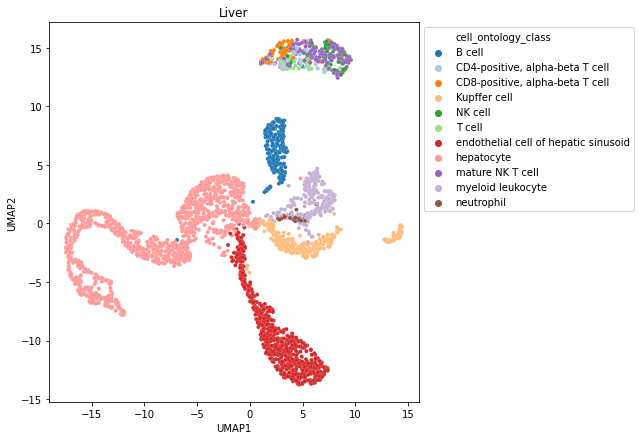

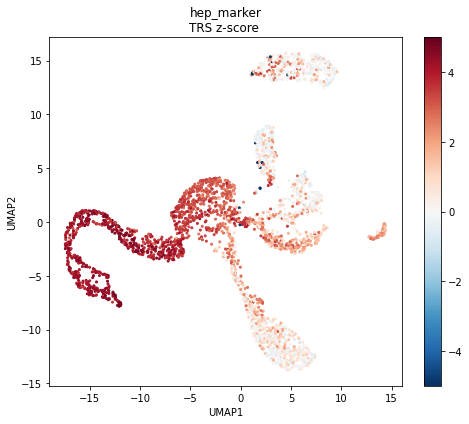

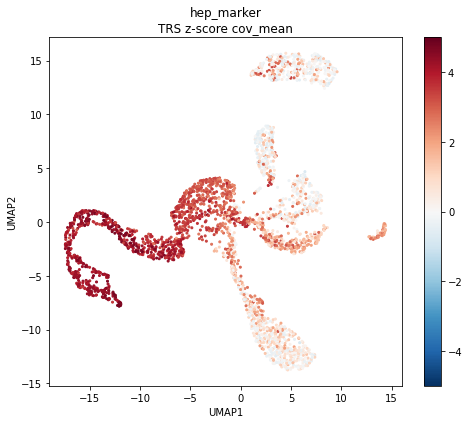

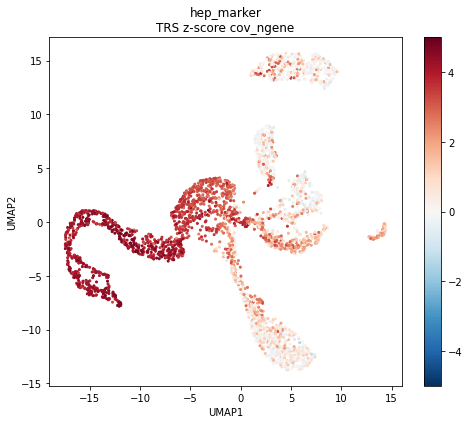

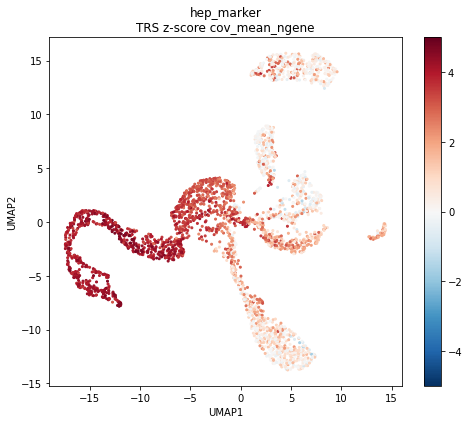

In [81]:
plot_list = [['Liver', 'hep_marker']]

tissue_plot = []
for tissue,trait in plot_list:
    
    temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
    temp_df['trs_ez'] = data=dic_trs['%s;trs_ez'%(trait)]
    temp_df['cov_mean;trs_ez'] = data=dic_trs['%s;mean;trs_ez'%(trait)]
    temp_df['cov_ngene;trs_ez'] = data=dic_trs['%s;ngene;trs_ez'%(trait)]
    temp_df['cov_mean_ngene;trs_ez'] = data=dic_trs['%s;mean_ngene;trs_ez'%(trait)]
    
    df_plot = pd.DataFrame(index=dic_data_facs[tissue].obs.index)
    df_plot['UMAP1'] = dic_data_facs[tissue].obsm['X_umap'][:,0]
    df_plot['UMAP2'] = dic_data_facs[tissue].obsm['X_umap'][:,1]
    df_plot['cell_ontology_class'] = dic_data_facs[tissue].obs['cell_ontology_class']
    
    df_plot['trs_ez'] = temp_df.loc[df_plot.index, 'trs_ez']
    df_plot['cov_mean;trs_ez'] = temp_df.loc[df_plot.index, 'cov_mean;trs_ez']
    df_plot['cov_ngene;trs_ez'] = temp_df.loc[df_plot.index, 'cov_ngene;trs_ez']
    df_plot['cov_mean_ngene;trs_ez'] = temp_df.loc[df_plot.index, 'cov_mean_ngene;trs_ez']
    
    temp_df = df_plot.groupby('cell_ontology_class').agg({'trs_ez':len})
    celltype_list = list(temp_df.index[temp_df['trs_ez']>25])
    celltype_list.sort()
    celltype_set = set(celltype_list)
    df_plot = df_plot.loc[[x in celltype_set for x in df_plot['cell_ontology_class']]]
    
    if len(celltype_list)<=10:
        palette='tab10'
    else:
        palette='tab20'
    
    if tissue not in tissue_plot:
        tissue_plot.append(tissue)
        plt.figure(figsize=[9,6])
        sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', 
                        hue='cell_ontology_class', hue_order=celltype_list, palette=palette,
                        s=16, linewidth=0.1)
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))
        plt.tight_layout()
        plt.title(tissue)
        plt.show()
    
    for term in ['trs_ez', 'cov_mean;trs_ez', 'cov_ngene;trs_ez', 'cov_mean_ngene;trs_ez']:
        plt.figure(figsize=[7,6])
        plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[term],
                    cmap='RdBu_r', vmin=-5, vmax=5, s=4)
        plt.colorbar()
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('%s\nTRS z-score %s'%(trait, term.replace('trs_ez','').replace(';','')))
        plt.tight_layout()
        plt.show()
#     break

### Old code